# Model Evaluation and Threshold Optimization
    From Model Scores to Business Decisions

##  Objective

This notebook provides a rigorous evaluation framework for classification models, covering:

- Why accuracy is misleading in risk modeling

- Proper use of ROC-AUC, PR-AUC, KS

- Threshold selection under asymmetric costs

- Precision–recall tradeoffs

- Business-aligned decision rules

It answers:

    How do we convert predicted probabilities into optimal, auditable decisions?

##  Business Context – Why Evaluation Is Hard in Banking

In credit risk:

- Defaults are rare

- False negatives are expensive

- False positives hurt revenue

- Regulators demand justification

> Model evaluation must be cost-aware, not metric-driven.

##  Imports and Dataset

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("D:/GitHub/Data-Science-Techniques/datasets/Supervised-classification/synthetic_credit_default_classification.csv")

df.head()


,customer_id,age,annual_income,credit_utilization,debt_to_income,loan_amount,loan_term_months,num_past_defaults,employment_years,credit_score,default
0,1,59,23283.682822,0.187813,0.245248,20232.165654,24,0,4.575844,689.627408,1
1,2,49,61262.608063,0.291774,0.396763,26484.067591,36,0,3.317515,697.770541,1
2,3,35,60221.743160,0.230557,0.122859,27142.522594,24,1,11.871955,713.721429,0
3,4,63,93603.112731,0.157906,0.635484,1000.000000,12,0,2.256651,655.306417,1
4,5,28,71674.557271,0.167549,0.422446,15254.246561,48,0,6.971270,644.247643,0


In [ ]:
target = "default"

X = df.drop(columns=[target, "customer_id"])
y = df[target]


# Train/Test Split (Stratified)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


# MODEL

Assume Random Forest is the selected challenger.

## Pipeline - Random Forest

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        min_samples_leaf=30,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

model.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        min_samples_leaf=30, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

## Probability Predictions

In [6]:
y_prob = model.predict_proba(X_test)[:, 1]


## Why Accuracy Is Dangerous

In [7]:
from sklearn.metrics import accuracy_score

y_pred_default = (y_prob >= 0.5).astype(int)
accuracy_score(y_test, y_pred_default)


0.812

High accuracy often means **rejecting nobody.**

## Confusion Matrix

In [8]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_default)


array([[537, 116],
       [ 72, 275]])

| Outcome | Meaning                  |
| ------- | ------------------------ |
| FN      | Default approved ❌       |
| FP      | Good customer rejected ❌ |



## ROC Curve & AUC

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_score(y_test, y_prob)


np.float64(0.8921757704410149)

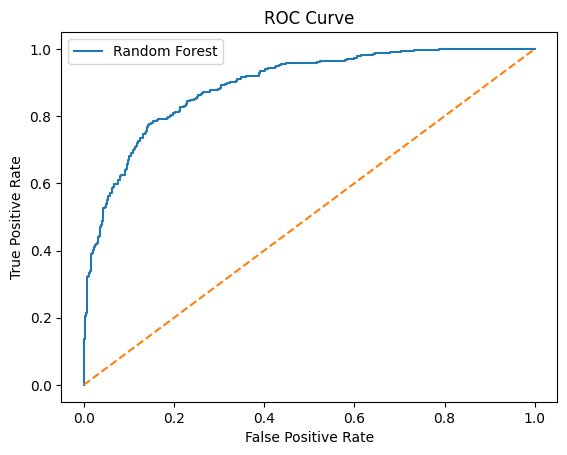

In [10]:
plt.plot(fpr, tpr, label="Random Forest")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


- `[pros] -` Measures ranking quality
- `[cons] -` Ignores class imbalance costs

## Precision–Recall Curve (More Relevant)

Advantages:
- Focuses on minority class
- Better for default detection

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)
average_precision_score(y_test, y_prob)


np.float64(0.8293178524894914)

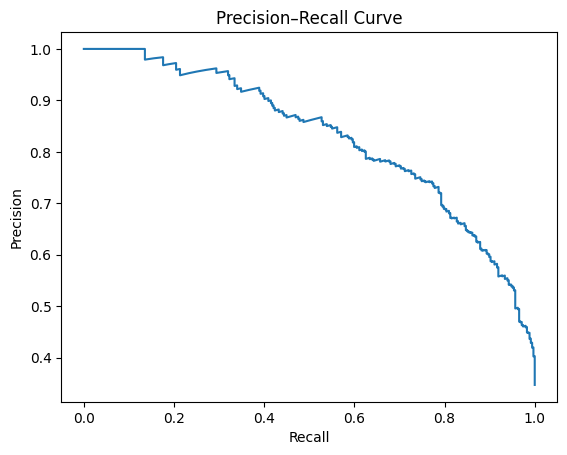

In [12]:
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()



## KS Statistic (Banking Standard)

In [13]:
ks = max(tpr - fpr)
ks


np.float64(0.6336041590354428)

## Threshold Optimization (Key Section)
Why 0.5 Is Arbitrary

Threshold depends on:

- Default cost

- Rejection cost

- Portfolio strategy

### Evaluate Thresholds

In [15]:
thresholds = np.linspace(0.01, 0.99, 100)

metrics = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    metrics.append({
        "threshold": t,
        "precision": tp / (tp + fp + 1e-6),
        "recall": tp / (tp + fn + 1e-6),
        "fpr": fp / (fp + tn + 1e-6)
    })

metrics_df = pd.DataFrame(metrics)
metrics_df#.head()


,threshold,precision,recall,fpr
0,0.010000,0.347347,1.000000,0.998469
1,0.019899,0.350151,1.000000,0.986217
2,0.029798,0.354443,1.000000,0.967841
3,0.039697,0.359585,1.000000,0.946401
4,0.049596,0.364879,1.000000,0.924962
...,...,...,...,...
95,0.950404,1.000000,0.017291,0.000000
96,0.960303,0.999999,0.002882,0.000000
97,0.970202,0.000000,0.000000,0.000000
98,0.980101,0.000000,0.000000,0.000000


## Cost-Sensitive Thresholding
Example Costs

- Default loss = 10

- Rejection loss = 1

### Cost Curve

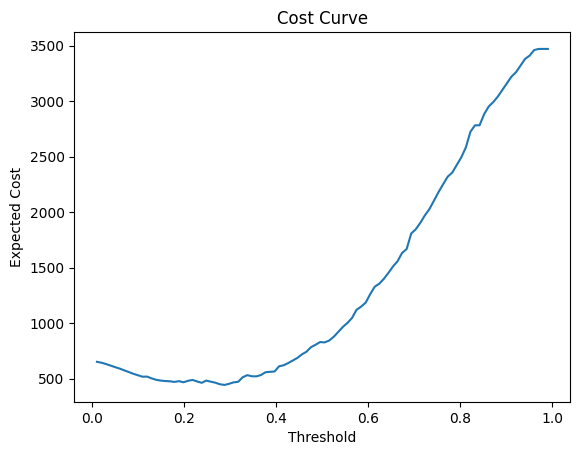

In [16]:
costs = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    cost = fn * 10 + fp * 1
    costs.append(cost)

plt.plot(thresholds, costs)
plt.xlabel("Threshold")
plt.ylabel("Expected Cost")
plt.title("Cost Curve")
plt.show()


## Optimal Threshold

In [17]:
optimal_threshold = thresholds[np.argmin(costs)]
optimal_threshold

np.float64(0.2871717171717172)

- `[pros] -` Business-aligned
- `[pros] -` Auditable
- `[pros] -` Defensible

## Final Decision Rule

In [24]:
y_pred_opt = (y_prob >= optimal_threshold).astype(int)
confusion_matrix(y_test, y_pred_opt)


array([[359, 294],
       [ 15, 332]])

In [25]:
y_pred = (y_prob >= t).astype(int)

In [27]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       653
           1       0.00      0.00      0.00       347

    accuracy                           0.65      1000
   macro avg       0.33      0.50      0.40      1000
weighted avg       0.43      0.65      0.52      1000



C:\Users\pantu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pantu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pantu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model Monitoring Implications

Thresholds must be:

- Re-evaluated over time

- Stable under drift

- Documented

##  Common Mistakes (Avoided)

- `[cons] -` Using accuracy
- `[cons] -` Fixing threshold at 0.5
- `[cons] -` Ignoring costs
- `[cons] -` Optimizing on test set repeatedly
- `[cons] -` No business rationale

##  Summary Table

| Concept     | Why It Matters      |
| ----------- | ------------------- |
| ROC-AUC     | Ranking quality     |
| PR-AUC      | Minority class      |
| KS          | Regulatory standard |
| Threshold   | Business decision   |
| Cost curves | Profit alignment    |



## Key Takeaways

 - Models predict probabilities, not decisions

 - Thresholds encode business policy

 - Cost matters more than AUC

 - Evaluation ≠ validation

 - Governance requires documentation

## Next Notebook


04_Supervised_Learning/

└── [05_probability_calibration_and_pd_modeling](05_probability_calibration_and_pd_modeling.ipynb)


<br><br><br><br><br>



# Complete: [Data Science Techniques](https://github.com/lei-soares/Data-Science-Techniques)

- [00_Data_Generation_and_Simulation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/00_Data_Generation_and_Simulation)


- [01_Exploratory_Data_Analysis_(EDA)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/01_Exploratory_Data_Analysis_(EDA))


- [02_Data_Preprocessing](https://github.com/lei-soares/Data-Science-Techniques/tree/main/02_Data_Preprocessing)


- [03_Feature_Engineering](https://github.com/lei-soares/Data-Science-Techniques/tree/main/03_Feature_Engineering)


- [04_Supervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/04_Supervised_Learning)

    - [Regression Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/01_regression_models)
    
    - [Classification Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/02_classification_models)


- [05_Unsupervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/05_Unsupervised_Learning)


- [06_Model_Evaluation_and_Validation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/06_Model_Evaluation_and_Validation)


- [07_Model_Tuning_and_Optimization](https://github.com/lei-soares/Data-Science-Techniques/tree/main/07_Model_Tuning_and_Optimization)


- [08_Interpretability_and_Explainability](https://github.com/lei-soares/Data-Science-Techniques/tree/main/08_Interpretability_and_Explainability)


- [09_Pipelines_and_Workflows](https://github.com/lei-soares/Data-Science-Techniques/tree/main/09_Pipelines_and_Workflows)


- [10_Natural_Language_Processing_(NLP)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/10_Natural_Language_Processing_(NLP))


- [11_Time_Series](https://github.com/lei-soares/Data-Science-Techniques/tree/main/11_Time_Series)


- [12_Anomaly_and_Fraud_Detection](https://github.com/lei-soares/Data-Science-Techniques/tree/main/12_Anomaly_and_Fraud_Detection)


- [13_Imbalanced_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/13_Imbalanced_Learning)


- [14_Deployment_and_Production_Concepts](https://github.com/lei-soares/Data-Science-Techniques/tree/main/14_Deployment_and_Production_Concepts)


- [15_Business_and_Experimental_Design](https://github.com/lei-soares/Data-Science-Techniques/tree/main/15_Business_and_Experimental_Design)




<br><br><br><br><br>

[Panfugo Dados](www.pantufodados.com)


[Pantufo Dados - YouTube Channel](https://www.youtube.com/@pantufodados)